#### Introduction

As a big fan of social table-top gaming, and all manner of board, card and dice games, I was thrilled to find a rich set of review data from BoardGameGeek.com [on kaggle](https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews/data?select=games_detailed_info2025.csv). The data consists of at least 15 million user reviews of various games on the site, with metadata on over 21 thousand distinct items (games).

Because that metadata is itself quite rich, it lends itself a content-based approach for recommender systems. Games are tagged with useful attributes like category and game mechanic, as well as numerical values like recommended player count, age and release date (which could be reduced to categories themselves as needed). I expect that with this approach, I could get a strong sense of what to recommend for, say, someone who wants quick card games for their kids, or someone who wants complex, violent war games for their adult friend group and everything in between.

But something else that really excited me about the data was that it includes a text description for each game as well. This affords me the opportunity to use a more "unstructured" data approach, converting those text strings into vectors, valued by wordcount or TF-IDF, and assessing potential recommendations that way. Then, I could compare which content-based approach is stronger, and make recommendations to game developers based on my findings--for example, to ensure that their descriptions are as detailed as possible, or that they tag their games accurately and comprehensively.


I'll start by importing the necessary packages, including those required to run my code here on the Microsoft Azure platform:

In [1]:
import os
from dotenv import load_dotenv
from azure.storage.filedatalake import DataLakeServiceClient

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ast

import scipy.sparse as sp
from scipy.sparse import coo_matrix
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from implicit.als import AlternatingLeastSquares
from tqdm.auto import tqdm

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#bring in .env which contains connection string
load_dotenv()

True

In [3]:
#connect to the account
conn_str = os.environ["AZURE_STORAGE_CONNECTION_STRING"]
service = DataLakeServiceClient.from_connection_string(conn_str)

#set filesystem and fs_client
filesystem = "raw-boardgames-data"
fs_client   = service.get_file_system_client(filesystem)

##### Review Data

Let's start by pulling in our review data, which I need to chunk in order to read efficiently.

In [4]:
#set filepath and file client
filepath   = "bgg-15m-reviews.csv"
file_client = fs_client.get_file_client(filepath)

In [5]:
#stream the CSV blob down to a local file
with open("bgg-15m-reviews.csv", "wb") as f:
    downloader = file_client.download_file()
    downloader.readinto(f)

#pick only necessary columns
usecols = ['user','rating','ID']

#read in chunks and concatenate
reader = pd.read_csv(
    "bgg-15m-reviews.csv",
    usecols=usecols,
    chunksize=100_000,
    dtype={"author_id": str, "podcast_id": str, "rating": float}
)

df_r = pd.concat(reader, ignore_index=True)

#clean up the on-disk file (csv no longer needed)
os.remove("bgg-15m-reviews.csv")

In [6]:
#inspect
print(df_r.shape)
df_r.head()

(15823269, 3)


,user,rating,ID
0,Torsten,10.0,30549
1,mitnachtKAUBO-I,10.0,30549
2,avlawn,10.0,30549
3,Mike Mayer,10.0,30549
4,Mease19,10.0,30549


This looks perfect, as we have all we need for our interactions data: a username, their rating of a particular game, and the ID of that game (which corresponds to our board game metadata). Speaking of:

##### Board Game metadata

We can now pull in the board game data in a similar fashion:

In [7]:
#set filepath and file client
filepath   = "games_detailed_info2025.csv"
file_client = fs_client.get_file_client(filepath)

In [8]:
#stream the CSV blob down to a local file
with open("games_detailed_info2025.csv", "wb") as f:
    downloader = file_client.download_file()
    downloader.readinto(f)

#read in chunks and concatenate
reader = pd.read_csv(
    "games_detailed_info2025.csv",
    #usecols=usecols,
    chunksize=100_000,
    dtype={"author_id": str, "podcast_id": str, "rating": float}
)

df_bg = pd.concat(reader, ignore_index=True)

#clean up the on-disk file (csv no longer needed)
os.remove("games_detailed_info2025.csv")

##### Exploratory Data Analysis

Let's start by analyzing our ratings data, as it is less complex then our game metadata and can give us a quick sense of our review distribution. We can also get a sense of user and game volume, which we can then use to filter down the board game data to make it a bit less noisy, while retaining the benefits of high volume.

In [9]:
df_r['rating'].value_counts()

7.00000    3566154
8.00000    3002815
6.00000    2346047
9.00000    1424911
5.00000    1077762
            ...   
8.10675          1
9.95556          1
8.76598          1
8.42800          1
4.33375          1
Name: rating, Length: 10172, dtype: int64

In [10]:
#divide num of integer ratings by total ratings
len(df_r[df_r['rating'].isin(range(0,11))]) / len(df_r)

0.829082789403378

Interesting! Seems like the values allow for float entries, though the large majority of ratings are indeed integers. I'm not sure why some individual ratings have such a high level of precision, but I believe it makes sense to simplify them all to the same level (ie. rounded to the nearest 10th place) and work from there.

In [11]:
df_r['rating'] = df_r['rating'].apply(lambda x: round(x,1))

<Axes: >

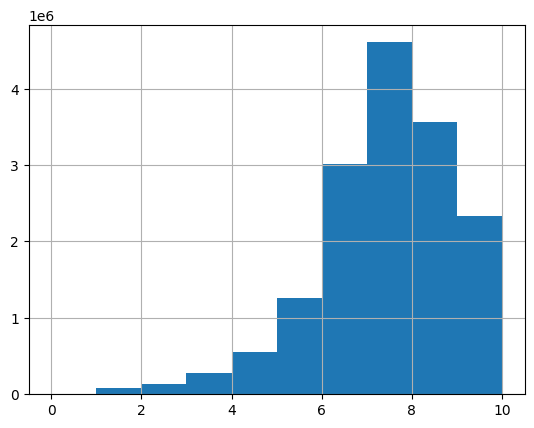

In [12]:
#now observe distribution
df_r['rating'].hist()

This looks like a sensible distribution, relatively normal with most ratings sitting in the high-but-not-extreme range of 6-9 and a leftward skew. 10s are common but not easy to come by, suggesting we have a discerning audience.

Next, we want to filter down our data only to users and board games with a mininum number of ratings corresponding to the ~90th percentile, ensuring that users and games with very few ratings don't clutter our classifier.

In [13]:
#90th percentile of users
np.percentile(df_r['user'].value_counts(), 80)

57.0

In [14]:
#90th percentile of games
np.percentile(df_r['ID'].value_counts(), 80)

525.2000000000007

Now we can filter down the ratings data based on these figures. This needs to be done on a loop as the loss of games iteratively impacts the number of users meeting the criteria and vice versa.

In [15]:
MIN_GAME_RATINGS = 500
MIN_USER_RATINGS = 50

df_r2 = df_r.copy()

while True:
    before = df_r2.shape[0]
    
    #drop games with too few reviews
    df_r2 = df_r2.groupby('ID').filter(lambda x: len(x) >= MIN_GAME_RATINGS)
    #drop users with too few reviews
    df_r2 = df_r2.groupby('user').filter(lambda x: len(x) >= MIN_USER_RATINGS)
    
    after = df_r2.shape[0]
    if after == before:
        break

In [16]:
df_r2['user'].value_counts()

leffe dubbel    3042
JasonSaastad    2365
TomVasel        2307
Hessu68         2306
Doel            2226
                ... 
shawnmain         50
Alatazans         50
bennettboy        50
Sandevid          50
Lundi_tabula      50
Name: user, Length: 71058, dtype: int64

In [17]:
df_r2['ID'].value_counts()

30549     50338
822       49201
13        46833
68448     46811
36218     43398
          ...  
186995      500
3341        500
2767        500
281152      500
217362      500
Name: ID, Length: 3493, dtype: int64

Perfect--now we can filter down our board game data to correspond with the new ratings:

In [18]:
df_bg2 = df_bg[df_bg['id'].isin(df_r2['ID'].value_counts().index)]

In [19]:
#make column names consistent
df_r2.rename(columns={'ID':'game_id'}, inplace = True)
df_bg2.rename(columns={'id':'game_id'}, inplace = True)

/tmp/ipykernel_50357/865567345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2.rename(columns={'id':'game_id'}, inplace = True)


###### Descriptions

Let's start by analyzing our raw-text descriptions. I'm curious to see the length distribution and check for anomalies:

<Axes: >

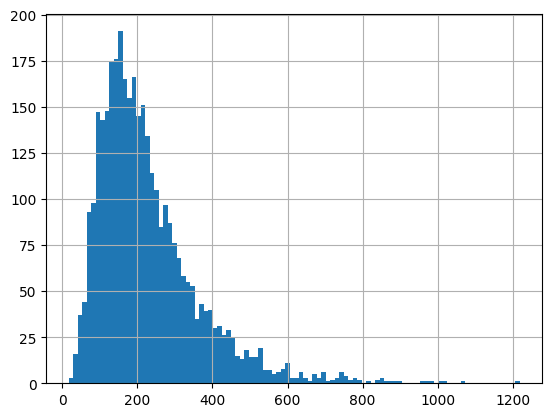

In [20]:
#histogram of rough word count
df_bg2['description'].apply(lambda x: len(x.split(' '))).hist(bins=100)

Looks to be quite normally distributed, with descriptions tending toward a couple hundred words, skewing right with a few larger (but not outrageous) outliers. This should be suitable for a TF-IDF vectorization. Let's take a quick look at some descriptions to get a sense of what they include:

In [21]:
for i in range(0, 3):
    print(str.upper(df_bg2.sample(5, random_state=910)[['name','description']].iloc[i,0]))
    print(df_bg2.sample(5, random_state=910)[['name','description']].iloc[i,1])

CARTOGRAPHERS
Queen Gimnax has ordered the reclamation of the northern lands. As a cartographer in her service, you are sent to map this territory, claiming it for the Kingdom of Nalos. Through official edicts, the queen announces which lands she prizes most, and you will increase your reputation by meeting her demands. But you are not alone in this wilderness. The Dragul contest your claims with their outposts, so you must draw your lines carefully to reduce their influence. Reclaim the greatest share of the queen&rsquo;s desired lands and you will be declared the greatest cartographer in the kingdom.&#10;&#10;In Cartographers: A Roll Player Tale, players compete to earn the most reputation stars by the time four seasons have passed. Each season, players draw on their map sheets and earn reputation by carrying out the queen's edicts before the season is over. The player with the most reputation stars at the end of winter wins!&#10;&#10;&mdash;description from the publisher&#10;&#10;
P

From this sample, we can get a sense of the thematic ideas occurring in the descriptions. My anecdotal sense is that the descriptions provide more of a "vibe-based" overview of the games, describing the aesthetics, style and mood rather than delving deeply into the mechanics. Therefore, a recommender based on these descriptions may help us identify whether that tends to be a deciding factor for game enjoyers (ie. games about fantastical realms or modern Europe) as opposed to functionality concerns.

###### Categorical Features

Apart from the text description, we have a number of columns that tell us valuable information about game functionality and mechanics. Let's examine them, filter down to those we expect to be predictive in some way, and re-format the data to be classifier friendly.

In [22]:
df_bg2.columns

Index(['Unnamed: 0', 'type', 'game_id', 'thumbnail', 'image', 'alternate',
       'description', 'yearpublished', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage',
       'suggested_language_dependence', 'playingtime', 'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic',
       'boardgamefamily', 'boardgameexpansion', 'boardgameaccessory',
       'boardgamecompilation', 'boardgameimplementation', 'boardgamedesigner',
       'boardgameartist', 'boardgamepublisher', 'usersrated', 'average',
       'bayesaverage', 'Board Game Rank', 'Strategy Game Rank',
       'Family Game Rank', 'stddev', 'median', 'owned', 'trading', 'wanting',
       'wishing', 'numcomments', 'numweights', 'averageweight',
       'boardgameintegration', 'Abstract Game Rank', 'Party Game Rank',
       'Thematic Rank', 'War Game Rank', 'Customizable Rank',
       'Children's Game Rank', 'RPG Item Rank', 'Accessory Rank', 'name'],
      dtype='object')

Based on these columns, I want to focus on those describing: when the game was published, player number, player age, playing time, category, and mechanic. The rest appear to be more about how the games have been rated, and I know those contain many null values (and besides, we have much more detailed rating data in df_r2).

In [23]:
#c for categorical features
df_bg2_c = df_bg2[['game_id', 'name', 'yearpublished', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage','playingtime', 'minplaytime','maxplaytime', 
       'minage', 'boardgamecategory', 'boardgamemechanic']]

In [24]:
df_bg2_c.head()

,game_id,name,yearpublished,minplayers,maxplayers,suggested_num_players,suggested_playerage,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic
0,13,CATAN,1995,3,4,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '1'}, {'@value':...",120,60,120,10,"['Economic', 'Negotiation']","['Chaining', 'Dice Rolling', 'Hexagon Grid', '..."
1,822,Carcassonne,2000,2,5,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '2'}, {'@value':...",45,30,45,7,"['Medieval', 'Territory Building']","['Area Majority / Influence', 'Enclosure', 'Ma..."
2,30549,Pandemic,2008,2,4,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",45,45,45,8,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma..."
3,68448,7 Wonders,2010,2,7,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",30,30,30,10,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Closed Drafting', 'Hand Management', 'Neighb..."
4,167791,Terraforming Mars,2016,1,5,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",120,120,120,12,"['Economic', 'Environmental', 'Industry / Manu...","['Closed Drafting', 'Contracts', 'End Game Bon..."


Let's now go factor by factor and try to make sense of and ultimately consolidate these features.

**Publication Date**

<Axes: >

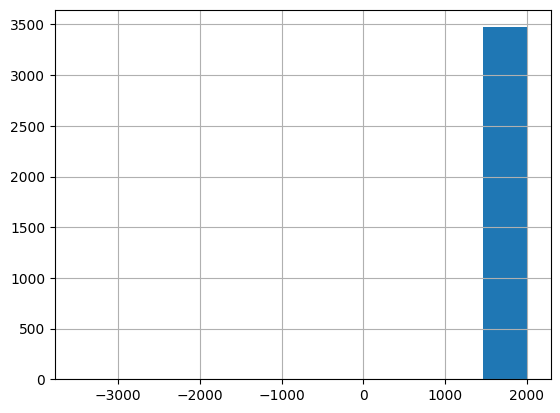

In [25]:
df_bg2_c['yearpublished'].hist()

Yikes! I was expecting to get a few decades in here, but it looks like we have a number of ancient games throwing off the distribution. Let's take a look:

In [26]:
df_bg2_c.sort_values(by='yearpublished').head(20)

,game_id,name,yearpublished,minplayers,maxplayers,suggested_num_players,suggested_playerage,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic
4210,2399,Senet,-3500,2,2,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",30,30,30,6,"['Abstract Strategy', 'Religious']","['Dice Rolling', 'Roll / Spin and Move']"
254,188,Go,-2200,2,2,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '3'}, {'@value':...",180,30,180,8,['Abstract Strategy'],"['Chaining', 'Enclosure', 'Pattern Building', ..."
2528,3886,Nine Men's Morris,-1400,2,2,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",20,20,20,6,['Abstract Strategy'],"['Pattern Building', 'Point to Point Movement']"
1192,11901,Tic-Tac-Toe,-1300,2,2,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '7'}, {'@value':...",1,1,1,4,"['Abstract Strategy', ""Children's Game""]","['Paper-and-Pencil', 'Pattern Building', 'Squa..."
999,5432,Chutes and Ladders,-200,2,6,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '5'}, {'@value':...",30,30,30,3,"['Animals', ""Children's Game"", 'Movies / TV / ...","['Events', 'Race', 'Roll / Spin and Move', 'Tr..."
2566,30618,Eat Poop You Cat,0,3,99,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",20,20,20,0,"['Humor', 'Party Game']","['Drawing', 'Paper-and-Pencil']"
3244,11017,Crazy Eights,0,2,5,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '1'}, {'@value':...",20,20,20,4,"['Card Game', ""Children's Game"", 'Number']","['Hand Management', 'Matching']"
2541,16398,War,0,2,2,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",30,30,30,4,"['Card Game', ""Children's Game""]",NaN
2286,7682,Go Fish,0,2,6,"[{'@numplayers': '1', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '0'}, {'@value':...",20,20,20,4,"['Card Game', ""Children's Game"", 'Deduction', ...","['Memory', 'Set Collection']"
3309,21804,Traditional Card Games,0,0,0,"{'@numplayers': '0+', 'result': [{'@value': 'B...","[{'@value': '2', '@numvotes': '1'}, {'@value':...",0,0,0,0,"['Card Game', 'Game System']",NaN


Let's make pre-1900 its own category, then otherwise class games by their decade:

In [27]:
def return_decade(yearpublished):
    '''returns lowest multiple of 10, or 1900 if prior to. Value returned as string
    to ensure treated as category rather than numerical val'''
    if yearpublished < 1900:
        return "pre_1900"
    else:
        return str((yearpublished // 10) * 10)+'s'

In [28]:
df_bg2_c['yearpublished'] = df_bg2_c['yearpublished'].apply(return_decade)

/tmp/ipykernel_50357/1125526808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['yearpublished'] = df_bg2_c['yearpublished'].apply(return_decade)


In [29]:
df_bg2_c['yearpublished'].value_counts()

2010s       1964
2000s        958
1990s        276
1980s        114
1970s         67
pre_1900      45
1960s         31
1950s          8
1940s          8
2020s          7
1930s          6
1900s          3
1920s          3
Name: yearpublished, dtype: int64

For size reasons, let's reduce these values one more time:

In [30]:
def final_filter_year(year_cat):
    '''An additional layer of filtering for year categories to reduce count'''
    if year_cat in ['2010s', '2020s']:
        return '2010s_20s'
    elif year_cat in ['1980s','1990s']:
        return '1980s_90s'
    elif year_cat in ['1960s','1970s']:
        return '1960s_70s'
    elif year_cat in ['1900s','1910s','1920s','1930s','1940s','1950s']:
        return 'early_through_mid_1900s'
    else:
        return year_cat

In [31]:
df_bg2_c['yearpublished'] = df_bg2_c['yearpublished'].apply(final_filter_year)

/tmp/ipykernel_50357/2918233092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['yearpublished'] = df_bg2_c['yearpublished'].apply(final_filter_year)


**Player Count**

Based on my domain knowledge of board games, I anticipate they should be judged not on a subjective sense of the 'best' number of players for the game, but whether it is possible to play with x players. Therefore, I'll convert the min and max columns into a list of the range of possibilities for each game. That way, each *possible* player count becomes a feature in my final data.

In [32]:
df_bg['maxplayers'].value_counts().sort_index(ascending=False)

999       2
362       1
163       1
127       1
120       1
100      31
99      288
80        1
75        1
69        2
68        1
64        1
60        1
52        2
50        9
48        1
45        1
44        1
42        1
41        1
40        7
38        1
36       15
34        1
33        2
32        5
31        1
30       20
28        2
26        1
25        3
24       22
23        2
22        7
21        4
20       94
18       11
17        6
16       76
15       55
14       15
13       10
12      301
11       17
10      523
9       101
8      1525
7       388
6      4968
5      3874
4      8966
3       360
2      5272
1       603
0       174
Name: maxplayers, dtype: int64

The long tail above 8 players could add noise to my data, so I'll cap it there and make a "more than 8" category to account for the rest.

In [33]:
df_bg2_c['maxplayers'] = df_bg2_c['maxplayers'].apply(lambda x: min(x, 9))

/tmp/ipykernel_50357/2545089138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['maxplayers'] = df_bg2_c['maxplayers'].apply(lambda x: min(x, 9))


In [34]:
df_bg2_c['player_range'] = df_bg2_c.apply(
    lambda row: list(range(row['minplayers'], row['maxplayers'] + 1)),
    axis=1)

/tmp/ipykernel_50357/1532400796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['player_range'] = df_bg2_c.apply(


In [35]:
df_bg2_c.drop(columns=['minplayers','maxplayers','suggested_num_players'],
                        inplace=True)

/tmp/ipykernel_50357/3724207813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c.drop(columns=['minplayers','maxplayers','suggested_num_players'],


In [36]:
df_bg2_c['player_range'] = df_bg2_c['player_range'].apply(lambda lst: ["more_than_8" if x == 9 else str(x) for x in lst])

/tmp/ipykernel_50357/601768594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['player_range'] = df_bg2_c['player_range'].apply(lambda lst: ["more_than_8" if x == 9 else str(x) for x in lst])


**Player Age Group**

In [37]:
df_bg2_c['minage'].value_counts().sort_index()

0      20
2       1
3      10
4      28
5      25
6      80
7      94
8     714
9      67
10    834
11     15
12    774
13    321
14    451
15     21
16     15
17     11
18      9
Name: minage, dtype: int64

Once again relying on the developers, I can see that the minimum age maps pretty neatly into three categories: 8 and below, 9 to 12, and 13 and up. While these figures skew younger than the probable player bases, the idea is that they speak to a maturity needed for playing (ie. 13+ games are not only for teenagers, just as PG-13 movies are enjoyed by many adults). I'll re-do the categories accordingly.

In [38]:
def set_age_category(minage):
    '''Convert minimum age provided by developer to minage_cat string val'''
    if minage <=8:
        return 'less_than_8'
    elif minage <=12:
        return '9_to_12'
    else:
        return '13_and_up'

In [39]:
df_bg2_c['min_age_range'] = df_bg2_c['minage'].apply(set_age_category)

/tmp/ipykernel_50357/2074010653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['min_age_range'] = df_bg2_c['minage'].apply(set_age_category)


In [40]:
df_bg2_c.drop(columns=['suggested_playerage','minage'], inplace=True)

/tmp/ipykernel_50357/4127716041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c.drop(columns=['suggested_playerage','minage'], inplace=True)


**Playing Time**

We have three columns for playing time: playingtime, minplaytime, and maxplaytime. It appears playingtime is simply the same as the max 

In [41]:
(df_bg2_c['playingtime'] == df_bg2_c['maxplaytime']).value_counts()

True    3490
dtype: int64

For consistency's sake, even though these are numeric values, as with publication year I want to instead treat them like categories. That means grouping them based on either min, average or max play time in a way that maps to real world use cases.

In [42]:
df_bg2_c['maxplaytime'].value_counts().sort_index()

0          4
1          4
2          1
5         11
6          1
10        62
13         1
15       145
20       264
25        37
30       584
32         1
35        14
40        99
42         1
45       461
50        21
55         2
60       628
70         9
72         1
75        67
80        17
90       393
95         1
100       18
105        1
110        2
115        1
120      340
125        2
135        2
150       37
165        1
180      128
200        4
210        5
240       61
270        2
300       15
360       24
420        2
480        8
720        3
999        1
1000       1
1200       1
6000       1
12000      1
Name: maxplaytime, dtype: int64

These figures also map quite neatly into categories based on playing time

In [43]:
def set_playtime_category(playingtime):
    '''Convert maximum playtime provided by developer to playtime_cat string val'''
    if playingtime <=30:
        return 'very short'
    elif playingtime <=60:
        return 'short'
    elif playingtime <=90:
        return 'medium'
    else:
        return 'long'

In [44]:
df_bg2_c['playtime_cat'] = df_bg2_c['playingtime'].apply(set_playtime_category)

/tmp/ipykernel_50357/1822557992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['playtime_cat'] = df_bg2_c['playingtime'].apply(set_playtime_category)


In [45]:
df_bg2_c['playtime_cat'].value_counts()

short         1227
very short    1114
long           662
medium         487
Name: playtime_cat, dtype: int64

In [46]:
df_bg2_c.drop(columns=['playingtime','minplaytime','maxplaytime'],inplace=True)

/tmp/ipykernel_50357/1164230383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c.drop(columns=['playingtime','minplaytime','maxplaytime'],inplace=True)


**Category**

In [47]:
df_bg2_c['boardgamecategory'][0]

"['Economic', 'Negotiation']"

These appear meant to be lists but are actually strings. That means I need to interpret them literally before analysis

In [48]:
df_bg2_c['boardgamecategory'] = df_bg2_c['boardgamecategory'].fillna('[]').apply(ast.literal_eval)

/tmp/ipykernel_50357/704732331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['boardgamecategory'] = df_bg2_c['boardgamecategory'].fillna('[]').apply(ast.literal_eval)


Because there's a long tail of categories, let's consider only the top 50:

In [49]:
keep_cats = pd.Series(df_bg2_c['boardgamecategory'].sum()).value_counts()[:50].index

Some categories are major, while others only apply to a few games. Let's only keep the heavy hitters to avoid introducing noise into our model:

In [50]:
df_bg2_c['boardgamecategory'] = df_bg2_c['boardgamecategory'].apply(lambda x: [str.lower(elem).replace(' ','_') for elem in x if elem in keep_cats])

/tmp/ipykernel_50357/2192080588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['boardgamecategory'] = df_bg2_c['boardgamecategory'].apply(lambda x: [str.lower(elem).replace(' ','_') for elem in x if elem in keep_cats])


**Board Game Mechanic**

In [51]:
df_bg2_c['boardgamemechanic'][0]

"['Chaining', 'Dice Rolling', 'Hexagon Grid', 'Income', 'Modular Board', 'Negotiation', 'Network and Route Building', 'Race', 'Random Production', 'Trading', 'Variable Set-up']"

Here we have the same issue as above, and need to convert these "string lists" to simple lists:

In [52]:
df_bg2_c['boardgamemechanic'] = df_bg2_c['boardgamemechanic'].fillna('[]').apply(ast.literal_eval)

/tmp/ipykernel_50357/2164212870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['boardgamemechanic'] = df_bg2_c['boardgamemechanic'].fillna('[]').apply(ast.literal_eval)


And we'll use a similar logic for retaining mechanics:

In [53]:
keep_mech = pd.Series(df_bg2_c['boardgamemechanic'].sum()).value_counts()[:50].index

In [54]:
df_bg2_c['boardgamemechanic'] = df_bg2_c['boardgamemechanic'].apply(lambda x: [str.lower(elem).replace(' ','_') for elem in x if elem in keep_mech])

/tmp/ipykernel_50357/763277973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg2_c['boardgamemechanic'] = df_bg2_c['boardgamemechanic'].apply(lambda x: [str.lower(elem).replace(' ','_') for elem in x if elem in keep_mech])


In [55]:
df_bg2_c.head()

,game_id,name,yearpublished,boardgamecategory,boardgamemechanic,player_range,min_age_range,playtime_cat
0,13,CATAN,1980s_90s,"[economic, negotiation]","[dice_rolling, hexagon_grid, income, modular_b...","[3, 4]",9_to_12,long
1,822,Carcassonne,2000s,"[medieval, territory_building]","[area_majority_/_influence, enclosure, pattern...","[2, 3, 4, 5]",less_than_8,short
2,30549,Pandemic,2000s,[],"[action_points, cooperative_game, hand_managem...","[2, 3, 4]",less_than_8,short
3,68448,7 Wonders,2010s_20s,"[ancient, card_game, city_building, civilizati...","[hand_management, set_collection, simultaneous...","[2, 3, 4, 5, 6, 7]",9_to_12,very short
4,167791,Terraforming Mars,2010s_20s,"[economic, industry_/_manufacturing, science_f...","[contracts, end_game_bonuses, hand_management,...","[1, 2, 3, 4, 5]",9_to_12,long


In [56]:
#make game_id the index
df_bg2_c.set_index('game_id', inplace=True)

#### Categorical Content-Based Recommender

My first recommender system will be content-based, relying on the features we just cleaned and developed. This should help us recommend games to people based on their known preferences for things like gameplay lengths, mechanics, themes and age groups. First, I want to split my data into training and test sets so I can eventually evaluate my recommender.

In [57]:
#only keep users with ≥2 ratings so we can hold one out
user_counts = df_r2['user'].value_counts()
eligible   = user_counts[user_counts >= 2].index
df2        = df_r2[df_r2['user'].isin(eligible)]

#for each user, randomly hold out one interaction
rng = np.random.default_rng(905)
test_idxs = (
    df2
    .groupby('user', group_keys=False)
    .apply(lambda grp: grp.sample(1, random_state=905))
    .index
)
df_test  = df2.loc[test_idxs].reset_index(drop=True)
df_train = df2.drop(test_idxs).reset_index(drop=True)

print(f"Train interactions: {len(df_train):,},  Test interactions: {len(df_test):,}")

Train interactions: 10,303,961,  Test interactions: 71,058


Next, we need to convert df_bg2_c into a proper item x feature matrix, such that each variable represents a simple yes/no 1/0 binary for whether the board game has that feature or not (ie. published in the last 20 years, playable by 3 people, playable by 4 people, involving dice-rolling etc.)

In [58]:
#split cols into whether they contain single or multiple vals
single_cats = ['yearpublished', 'min_age_range', 'playtime_cat']
multi_cats = ['boardgamecategory', 'boardgamemechanic','player_range']

In [59]:
#single category dummy matrices
df_bg2_c_year = pd.get_dummies(df_bg2_c['yearpublished'].astype(str), prefix='year')
df_bg2_c_age = pd.get_dummies(df_bg2_c['min_age_range'].astype(str), prefix='age')
df_bg2_c_time = pd.get_dummies(df_bg2_c['playtime_cat'].astype(str), prefix='time')

In [60]:
#multiple category dummy matrices
mlb_pr = MultiLabelBinarizer(sparse_output=False)
df_bg2_c_cat  = pd.DataFrame(
    mlb_pr.fit_transform(df_bg2_c['boardgamecategory']),
    index=df_bg2_c.index,
    columns=[f"cat_{c}" for c in mlb_pr.classes_]
)

mlb_pr = MultiLabelBinarizer(sparse_output=False)
df_bg2_c_mech  = pd.DataFrame(
    mlb_pr.fit_transform(df_bg2_c['boardgamemechanic']),
    index=df_bg2_c.index,
    columns=[f"mech_{c}" for c in mlb_pr.classes_]
)

mlb_pr = MultiLabelBinarizer(sparse_output=False)
df_bg2_c_players  = pd.DataFrame(
    mlb_pr.fit_transform(df_bg2_c['player_range']),
    index=df_bg2_c.index,
    columns=[f"players_{c}" for c in mlb_pr.classes_]
)

In [61]:
#concatenate into one DataFrame
item_feats = pd.concat([df_bg2_c_year, df_bg2_c_age, df_bg2_c_time,
                        df_bg2_c_cat, df_bg2_c_mech, df_bg2_c_players], axis=1)
print("Item–feature matrix shape:", item_feats.shape)

Item–feature matrix shape: (3490, 123)


In [64]:
item_feats.head()

,year_1960s_70s,year_1980s_90s,year_2000s,year_2010s_20s,year_early_through_mid_1900s,year_pre_1900,age_13_and_up,age_9_to_12,age_less_than_8,time_long,...,players_0,players_1,players_2,players_3,players_4,players_5,players_6,players_7,players_8,players_more_than_8
game_id,,,,,,,,,,,,,,,,,,,,,
13,0,1,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
822,0,0,1,0,0,0,0,0,1,0,...,0,0,1,1,1,1,0,0,0,0
30549,0,0,1,0,0,0,0,0,1,0,...,0,0,1,1,1,0,0,0,0,0
68448,0,0,0,1,0,0,0,1,0,0,...,0,0,1,1,1,1,1,1,0,0
167791,0,0,0,1,0,0,0,1,0,1,...,0,1,1,1,1,1,0,0,0,0


Next we need to build user profiles. I just want to merge the board game ids back in as my index first:

In [67]:
#extract item IDs and feature matrix
item_ids = item_feats.index.to_numpy()
X_items  = item_feats.to_numpy()

#build a lookup from game_id → row index in X_items
id2idx = {gid: idx for idx, gid in enumerate(item_ids)}

#define function to build user profiles
def build_user_profiles(ratings_df):
    """
    Build a dict of { user_id: profile_vector } where profile_vector
    is the weighted average of item feature rows (weights = ratings).
    """
    profiles = {}
    for user, grp in ratings_df.groupby("user"):
        # keep only ratings for games present in iteam_feats
        valid = grp[grp["game_id"].isin(id2idx)]
        if valid.empty:
            continue

        # map each game_id to its feature-row index
        idxs = [ id2idx[g] for g in valid["game_id"] ]
        weights = valid["rating"].to_numpy()

        # slice out the feature rows and compute weighted average
        mat = X_items[idxs]
        profile = (weights[:, None] * mat).sum(axis=0) / weights.sum()

        profiles[user] = profile

    return profiles

#build the profiles
user_profiles = build_user_profiles(df_train)


Each user profile here is effectively a weighted average of features the user *seems* to care about, based on the features of games they previously rated in our training data and how highly they rated them. We'll build recommendations for that user, and all of them, by looking for the closest matches to this user profile among real board games they haven't yet rated.

In [68]:
#what each user has already seen in train
train_seen = df_train.groupby('user')['game_id'].agg(set).to_dict()

#recommendation function
def recommend_for_user(uprof, seen_items, K=10):
    """
    uprof: 1D np.array user profile
    seen_items: set of game_ids the user rated in train
    returns: list of top-K recommended game_ids
    """
    # compute similarity to all items
    sims = cosine_similarity(uprof.reshape(1, -1), X_items).flatten()
    # mask out already-seen items
    for gid in seen_items:
        idx = id2idx.get(gid)
        if idx is not None:
            sims[idx] = -np.inf
    # grab top-K indices
    topk = np.argpartition(-sims, K)[:K]
    topk = topk[np.argsort(-sims[topk])]
    return [item_ids[i] for i in topk]

#try it for one user
example_user = next(iter(user_profiles))
recs5 = recommend_for_user(
    user_profiles[example_user],
    train_seen.get(example_user, set()),
    K=5
)
print(f"Top-5 recommendations for user {example_user}: {recs5}")

#evaluate Recall@K on test set
def recall_at_k(K=10):
    hits = 0
    total = 0
    for user, true_game in zip(df_test['user'], df_test['game_id']):
        prof = user_profiles.get(user)
        if prof is None:
            continue
        recs = recommend_for_user(prof, train_seen.get(user, set()), K)
        hits += int(true_game in recs)
        total += 1
    return hits / total if total else 0.0

for K in [5, 10, 20]:
    print(f"Recall@{K}: {recall_at_k(K):.4f}")

Top-5 recommendations for user -=Yod@=-: [137155, 235512, 96260, 223049, 1324]
Recall@5: 0.0035
Recall@10: 0.0067
Recall@20: 0.0123


Those figures are hard to evaluate without a baseline, so let's test them against a random sampling of games:

In [69]:
#random baseline
N = len(item_ids)
print("Random Recall@5:", 5/N)
print("Random Recall@10:", 10/N)
print("Random Recall@20:", 20/N)

Random Recall@5: 0.0014326647564469914
Random Recall@10: 0.0028653295128939827
Random Recall@20: 0.0057306590257879654


Wow--so my categorical feature recommender is considerably better than random! Still, there could be room to improve, and certainly to compare against other sorts of content-based recommenders.

#### Text-Focused Content-Based Recommender

Let's start by vectorizing our description field into 5k max features and removing English stop-words.

In [70]:
#index metadata by game_id (if you haven’t already)
df_desc = df_bg2.set_index("game_id")["description"]

In [71]:
#TF–IDF vectorize
tfv = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

#fit transform to matrix
tfidf_matrix = tfv.fit_transform(df_desc.values)

In [72]:
#dimensionality reduction with SVD
svd = TruncatedSVD(n_components=100, random_state=905)
X_text = svd.fit_transform(tfidf_matrix)

In [73]:
#build index mapping
item_ids = df_desc.index.to_numpy()
id2idx    = {gid:i for i,gid in enumerate(item_ids)}

#make user profiles from text features
def build_profiles_from_matrix(ratings_df, id2idx_map, feature_mat):
    profiles = {}
    for user, grp in ratings_df.groupby("user"):
        # keep only games that exist in our text feature matrix
        valid = grp[grp["game_id"].isin(id2idx_map)]
        if valid.empty:
            continue
        idxs    = [ id2idx_map[g] for g in valid["game_id"] ]
        weights = valid["rating"].to_numpy()
        mat     = feature_mat[idxs, :]              # slice rows
        prof    = (weights[:, None] * mat).sum(axis=0) / weights.sum()
        profiles[user] = prof
    return profiles

user_profiles_text = build_profiles_from_matrix(df_train, id2idx, X_text)
print("Built text-based profiles for", len(user_profiles_text), "users")

Built text-based profiles for 71058 users


Now that we have user profiles, we build recommendations and evaluate them against the test data as we did earlier.

In [74]:
#2hat each user has already seen in train
train_seen = df_train.groupby('user')['game_id'].agg(set).to_dict()

#4ecommend function
def recommend_for_user(uprof, seen, K=10):
    sims = cosine_similarity(uprof.reshape(1,-1), X_text).flatten()
    for gid in seen:
        idx = id2idx.get(gid)
        if idx is not None:
            sims[idx] = -np.inf
    topk = np.argpartition(-sims, K)[:K]
    topk = topk[np.argsort(-sims[topk])]
    return [item_ids[i] for i in topk]

#quick sanity check
u0 = next(iter(user_profiles_text))
print("Top-5 text-based recs for user", u0, recommend_for_user(
    user_profiles_text[u0], train_seen.get(u0, set()), K=5
))

#Recall@K
def recall_at_k_text(K=10):
    hits = 0
    total= 0
    for u,true in zip(df_test['user'], df_test['game_id']):
        prof = user_profiles_text.get(u)
        if prof is None:
            continue
        recs = recommend_for_user(prof, train_seen.get(u, set()), K)
        hits += int(true in recs)
        total+= 1
    return hits/total if total else 0.0

for K in [5, 10, 20]:
    print(f"Text Recall@{K}: {recall_at_k_text(K):.4f}")

Top-5 text-based recs for user -=Yod@=- [1044, 192638, 153999, 168054, 1041]
Text Recall@5: 0.0023
Text Recall@10: 0.0044
Text Recall@20: 0.0088


Wow--this remains better than random, but worse than both our popularity-based recommender and our categorical one! Let's try to combine the two:

#### Hybrid Content-Based Recommender

At this stage, we can combine our two separate approaches to see if our categorical and raw text features are complimentary.

In [75]:
#metadata block:
# item_feats is a DataFrame indexed by game_id, shape (n_items, 123)
item_ids = item_feats.index.to_numpy()     # [game_id_0, game_id_1, …]
X_meta   = item_feats.values               # shape (n_items, 123)

#Normalize & concatenate

#L2‐normalize each row in its own block
X_meta_norm = normalize(X_meta, axis=1)
X_text_norm = normalize(X_text, axis=1)

#optionally re‐weight blocks: here I keep them equal
alpha = 1.0
beta  = 1.0

X_hybrid = np.hstack([ alpha * X_meta_norm,
                       beta  * X_text_norm ])   # shape (n_items, 223)

#Build lookup & hybrid user profiles

#map game_id → row index
id2idx = {gid: i for i, gid in enumerate(item_ids)}

def build_hybrid_profiles(ratings_df):
    profiles = {}
    for user, grp in ratings_df.groupby("user"):
        valid = grp[grp["game_id"].isin(id2idx)]
        if valid.empty: continue

        idxs    = [id2idx[g] for g in valid["game_id"]]
        weights = valid["rating"].to_numpy()
        mat     = X_hybrid[idxs]               # (n_rated, 223)

        # weighted average
        prof    = (weights[:,None] * mat).sum(axis=0) / weights.sum()
        profiles[user] = prof
    return profiles

user_profiles_hybrid = build_hybrid_profiles(df_train)

#Recommendation and Eval

# what each user saw in train
train_seen = df_train.groupby("user")["game_id"].agg(set).to_dict()

def recommend_for_user(uprof, seen, K=10):
    sims = cosine_similarity(uprof.reshape(1,-1), X_hybrid).flatten()
    for gid in seen:
        idx = id2idx.get(gid)
        if idx is not None:
            sims[idx] = -np.inf
    topk = np.argpartition(-sims, K)[:K]
    topk = topk[np.argsort(-sims[topk])]
    return [item_ids[i] for i in topk]

def recall_at_k_hybrid(K=10):
    hits = total = 0
    for u, true in zip(df_test["user"], df_test["game_id"]):
        prof = user_profiles_hybrid.get(u)
        if prof is None: continue
        recs = recommend_for_user(prof, train_seen.get(u, set()), K)
        hits += int(true in recs)
        total += 1
    return hits/total if total else 0.0

for K in (5, 10, 20):
    print(f"Hybrid Recall@{K}: {recall_at_k_hybrid(K):.4f}")


Hybrid Recall@5: 0.0031
Hybrid Recall@10: 0.0061
Hybrid Recall@20: 0.0117


Interesting--these results mirror my category-focused recommender, suggesting those features could be doing most of the heavy lifting here, and the text descriptions (which focus more on game aesthetics) aren't doing much.

Below, I can run a quick, lean collaborative-filtering based model for the sake of comparison, to see if it would be worth pursuing that approach as an alternative.

In [76]:
# build user/item mappings
users    = df_train['user'].unique().tolist()
user2idx = {u:i for i,u in enumerate(users)}
items    = item_ids.tolist()
item2idx = {g:i for i,g in enumerate(items)}

# build user–item matrix
df_cf    = df_train[df_train['game_id'].isin(item2idx)]
rows     = df_cf['user'].map(user2idx).to_numpy(dtype=int)
cols     = df_cf['game_id'].map(item2idx).to_numpy(dtype=int)
data     = df_cf['rating'].to_numpy(dtype=float)
user_item = sp.coo_matrix((data, (rows, cols)),
                          shape=(len(users), len(items))).tocsr()

# fit and extract factors
model = AlternatingLeastSquares(factors=50,
                                regularization=0.01,
                                iterations=15)
model.fit(user_item)
user_factors = model.user_factors
item_factors = model.item_factors

#precompute seen
train_seen = df_train.groupby('user')['game_id'].agg(set).to_dict()

#compute recall@K
total = len(df_test)
for K in (5, 10, 20):
    hits = 0
    for user, true in zip(df_test['user'], df_test['game_id']):
        uidx = user2idx.get(user)
        if uidx is None: 
            continue
        scores = user_factors[uidx] @ item_factors.T
        for gid in train_seen.get(user, ()):
            idx = item2idx.get(gid)
            if idx is not None:
                scores[idx] = -np.inf
        topk = np.argpartition(-scores, K)[:K]
        hits += int(true in [items[j] for j in topk])
    print(f"cf recall@{K}: {hits/total:.4f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


cf recall@5: 0.1458
cf recall@10: 0.2206
cf recall@20: 0.3165


WOW! That's a **marked** improvement over any of my content-based models, speaking to the power of ALS with such a high volume of reviews to pull from, and reminding us of the limitations of content-based models when there are not terribly many features (category-based) or there are plenty, but they aren't necessarily reflective of the features that are important to users (text description-based).

#### Conclusion

I was somewhat, but not entirely surprised to see that my content-based recommender relying on gameplay features was more effective than the system using the text-based descriptions for each board game. This suggests that board game enthusiasts may be swayed more by things that have a material impact on the playing experience, such as playing time and game mechanics, than by thematics or aesthetics (ie. fantasy, science fiction, animals). This tracks with my own personal experience, as I tend to play board games in groups of 4-6, so oftentimes a 2-person or 8-person game simply won't interest me. A game's description may be, in some ways, window-dressing. For example, I love the game "Code Names," but not at all because it has a spy theme. Rather, I enjoy it because of the clever wordplay and teamwork aspects. I expect this is rather different than movies or TV shows, where preferences may well track along genre lines like spy thrillers, fantasy realms or superheroes.

It was also telling that my quick collaborative-filtering model, which I spent much less time developing, performed so much better in terms of recall than any of my content-based models. This shows the power of recommending based on like preferences, and the degree to which board game fans tend to cluster around certain categories of game. I would be interested to proceed with an even more hybrid model drawing on the strengths of my feature-based learnings and the recall gains from Alternating Least Squares. But ultimately, this speaks to the power of sheer memory and compute power. With so many reviews to learn from, a collaborative-filtering approach using ALS can be tough to beat.
